# Corona Tweets Classification using Keras:

### Package & Libraries:

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data reading

In [2]:
train = pd.read_csv('/Users/spavot/Documents/Perso/Text Classification/Data/Corona_NLP_train.csv', encoding = 'latin')
test = pd.read_csv('/Users/spavot/Documents/Perso/Text Classification/Data/Corona_NLP_test.csv', encoding ='latin')

## Data exploration:

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


* We see that we have 41157 values but we have only 32k non null values for location, we will have to fix this:

* UserName and ScreenName are id related data, we won't use it


Let's see which location is the more popular:

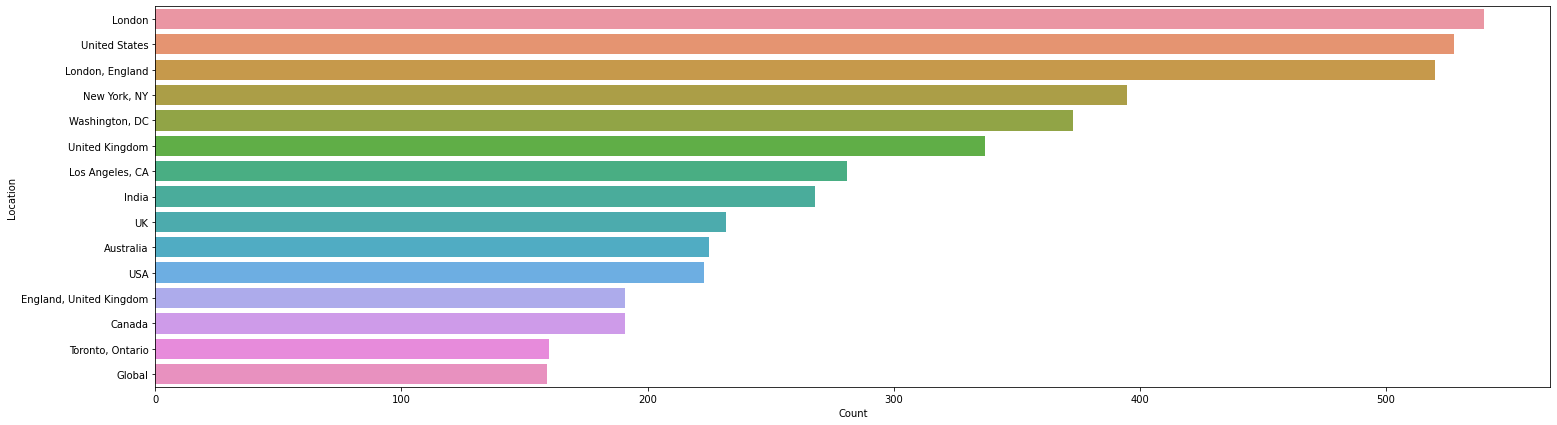

In [4]:
location = train.Location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('Location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()
plt.figure(figsize=(25,7))
sns.barplot(x = 'Count', y = 'Location', data = location)
plt.show()

We can see that we have some noises and some location are country where other are cities

Now we want to have a look of the distribution of our target variable:

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

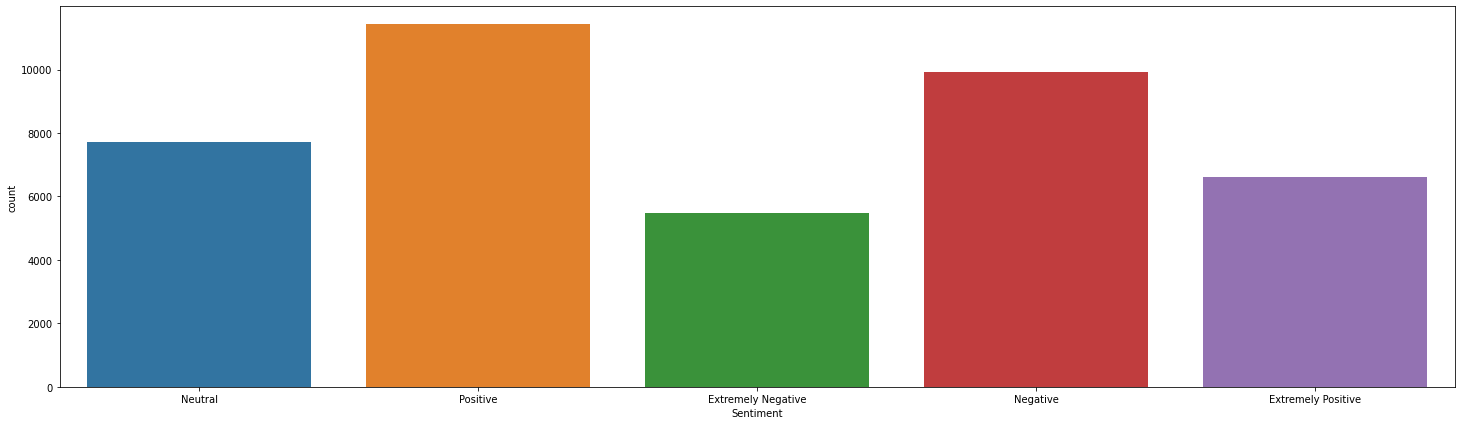

In [5]:
plt.figure(figsize=(25,7))
sns.countplot(train.Sentiment)

Seems like the target variable distribution is not skewed and we doesn't risk to have a category which is never predicted due to the lack of presence.

Let's look at the distribution of tweets over time:

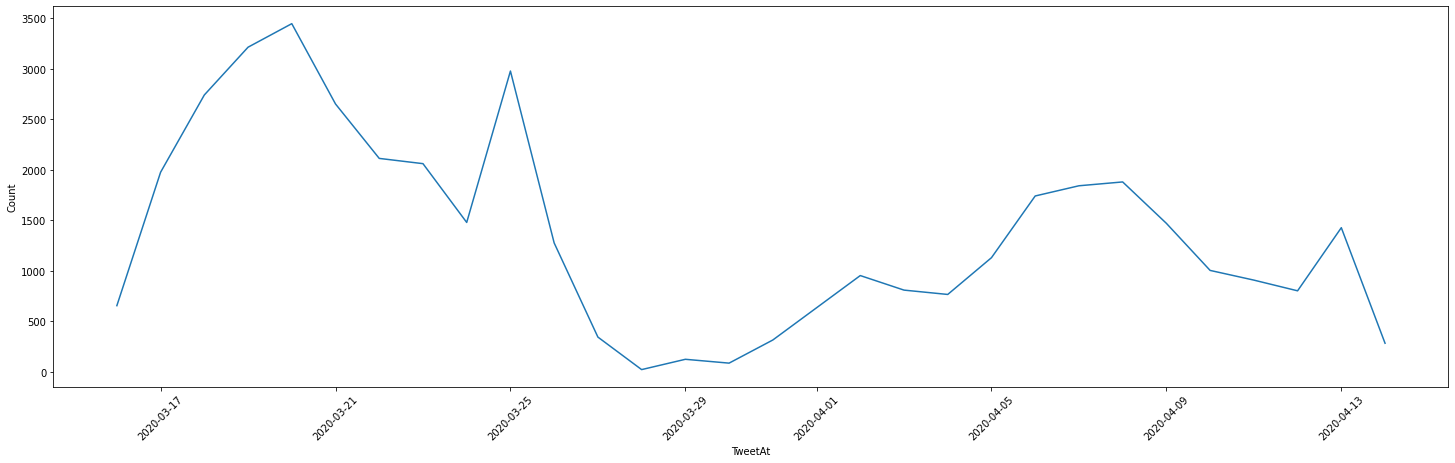

In [6]:
time = train.TweetAt
time = pd.DataFrame(time)
time['Count'] = 1
time = time.groupby('TweetAt').sum()
time = time.reset_index()
time = time.iloc[1:,:]
time['TweetAt'] = pd.to_datetime(time['TweetAt'], format = '%d-%m-%Y')
plt.figure(figsize=(25,7))
sns.lineplot(x = 'TweetAt', y = 'Count', data = time)
plt.xticks(rotation=45)
plt.show()

In [7]:
Min = time.TweetAt.min()
Max = time.TweetAt.max()
print(f'The date range of the data is between {Min} and {Max}')

The date range of the data is between 2020-03-16 00:00:00 and 2020-04-14 00:00:00


Seems like we have some day without data and some with a lot of tweets. The tweets are spread between 16 of March to 14 of April

Finally, let's analyze the lengths of tweets:

<AxesSubplot:>

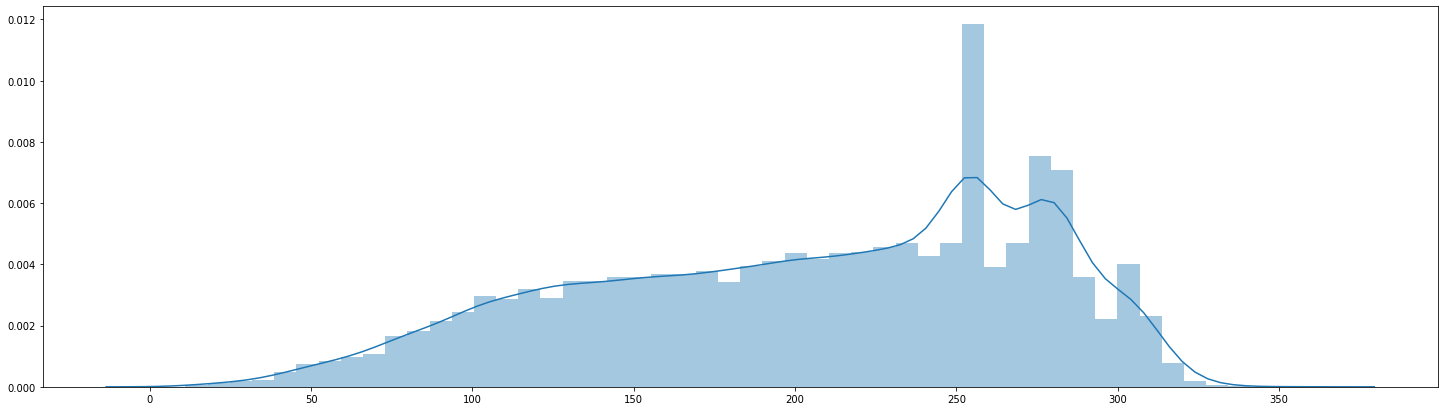

In [8]:
length_tweets = pd.DataFrame(train.OriginalTweet)
length_measured = []
for i in length_tweets.OriginalTweet:
 length_measured.append(len(i))

plt.figure(figsize=(25,7))
sns.distplot(length_measured)

It seems that the repartition is pretty well distributed, we can see a raise at 260 characters but overall we have tweets of all size. Note that we will have to check the length after processing the tweets

## Data cleaning:

### Drop variables

Let's first drop UserName and ScreenName as they are only id variables so we won't use them:

In [9]:
train = train.drop(['UserName','ScreenName'], axis = 1)
test = test.drop(['UserName','ScreenName'], axis = 1)

### Location variable

First, we will replace "NA" values with "Unknown"

In [10]:
train.Location = train.Location.fillna('Unknown')

Now we import a dataframe containg major cities in the word and countries in order join on it:

In [11]:
city_country = pd.read_csv('/Users/spavot/Documents/Perso/Text Classification/Data/world-cities.csv')

In [19]:
city_list = []

# for i in train.Location:
#     for y in city_country.name:
#         if y.lower() in i.lower():
#             city_name = y
#         else:
#             city_name = 'Unknown'
#     city_list.append(city_name)

In [20]:
# city_list = pd.DataFrame(city_list)
# city_list.value_counts()

Unknown    41157
dtype: int64

We transform the TweetAt column into time variable:

### TweetAt Variable

In [22]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = '%d-%m-%Y')

### Original tweet cleaning

Now we will start fixing the tweets, we need to remove the punctuation and specific characters etc.. 

In [26]:
train.OriginalTweet.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

Some tweets contains links, other seems to contains hashtags, we will have to extract them to give more information to our models.

In [29]:
#Transform to lower:
train.OriginalTweet = train.OriginalTweet.str.lower()
test.OriginalTweet = test.OriginalTweet.str.lower()